# Metrics

Implement metrics to evaluate clustering performance based on BCubed precision and recall [1].

From the original paper, layercluster is analog to image, trackster to cluster, and subject to simtrackster:

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{j \in T(i)}B(i, j)
$$

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{j \in L(i)}B(i, j)
$$

Where $T(i)$ is the trackster that contains layercluster $i$, and $L(i)$ are all layerclusters of the same simtrackster as layercluster $i$.

$B(i,j)$ is:
- 1 if a pair of layerclusters $(i, j)$ of the same simtrackster are in the same trackster
- 0 otherwise

Then the F-score is computed as:
$$
F_p = \frac{2P_bR_b}{P_b + R_b}
$$

## Multiple layerclusters per trackster

Each layer-cluster can be a part of multiple tracksters / simtracksters.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{|t|} \sum_{j \in t}B(i, j)
$$

Where $T(i)$ are the trackster**s** that contains layercluster $i$. $t$ is one of the tracksters that contain layercluster $i$.

$$
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{|l|} \sum_{j \in l}B(i, j)
$$

and $L(i)$ are all layerclusters of the same simtrackster**s** as layercluster $i$. $l$ are all layerclusters of one of the simtracksters that contain $i$.


$B(i,j)$ is:
- a fraction as tracksters the pair of layerclusters $(i, j)$ have in common
- 0 otherwise

## Energy-aware score

From TICL:
$$
multiplicity_{LC} = \frac{E_{LC}}{\sum_{LC}{{}_{hits}(fr_{hit}inSC * E_{hit})}}
$$

For each pair, multiply the score with the trackster energies:

$$
Pe_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|T(i)|} \sum_{t \in T(i)} \frac{1}{E(i, t)} \sum_{j \in t}B(i, j)E_t(i, j)
$$

Where $E(i, t)$ is the total energy of all trackster pairs between $i$ and $t$ and $E_t(i, j)$ is the layercluster pair energy of $i$ and $j$ in trackster $t$.

$$
Re_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{l \in L(i)} \frac{1}{E(l)} \sum_{j \in l}B(i, j)E_l(i,j)
$$

$B(i,j)$ is:
- the intersection over union of layercluster energy fractions

[1] Amigó, E., Gonzalo, J., Artiles, J. et al. A comparison of extrinsic clustering evaluation metrics based on formal constraints. Inf Retrieval 12, 461–486 (2009). https://doi.org/10.1007/s10791-008-9066-8

In [154]:
import uproot
import awkward as ak
import numpy as np
from utils.plotting_utils import plot_event
%matplotlib widget
# %matplotlib inline

file_name = "~/data/photon/new_ntuples_13872546_22.root"
# file_name = "~/data/multiparticle/new_ntuples_14132277_842.root"
# file_name = "~/data/data_fix_1.9/close_by_two_pions_15cm/new_ntuples_14955802_28.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Vertices in Tracksters and Simtracksters are in the same collection (with matching IDs).
- Not all vertices are present in the reconstruction

In [155]:
print(max(ak.flatten(tracksters["vertices_indexes"].array()[1])))
print(max(ak.flatten(simtracksters["stsSC_vertices_indexes"].array()[1])))
print(tracksters["NClusters"].array()[1])

331
340
341


In [226]:
def get_map(array, multi):
    i2o = {}
    for t_idx in range(len(array)):
        for i, m in zip(array[t_idx], multi[t_idx]):
            if i not in i2o:
                i2o[i] = []
            i2o[i].append((t_idx, 1. / m))
    return i2o

def get_E_map(tree, e_tree):
    # create map: vertex -> energy
    v2e = {}
    for t_idx in range(len(tree)):
        for i, e in zip(tree[t_idx], e_tree[t_idx]):
            v2e[i] = e
    return v2e

In [235]:
def B(i, j, mapping):
    """
    i and j are in the same trackster on one side
    are they also in a same trackster on the other side?
    """

    # no mapping, no match
    if not i in mapping or not j in mapping:
        return 0

    # get (sim-)tracksters of i and j on the other side
    it = np.array(mapping[i])
    jt = np.array(mapping[j])

    # find out how many are matching 
    _, i_idx, j_idx, = np.intersect1d(it[:,0], jt[:,0], return_indices=True)

    # sum of the intersection
    i_match_sum = it[i_idx][:,1].sum()
    j_match_sum = jt[j_idx][:,1].sum()

    # sum of the union
    i_sum = it[:,1].sum()
    j_sum = jt[:,1].sum()

    return (i_match_sum + j_match_sum) / (i_sum + j_sum)
    
def get_pairwise_scores(i, V, i2t, te_map):
    """
    Compute the score per trackster/simtrackster
    normalized by the number of pairs or total pair energy
    Inputs:
        i       target LC 
        V       L or C - all LCs of the trackster or simtrackster
        i2t     mapping from LC to its trackster or simtracksters on the oposite side
        te_map  (optional) LC -> energy in the given trackster
    Output:
        Normalized sum of the pair-wise scores
    """
    e_pairs = 0
    i_trackster_score = 0
    # for all vertices of the trackster
    for j in V:
        pair_score = B(i, j, i2t)
        if te_map:
            # multiply the score by the pair energy
            e_pair = te_map[i] * te_map[j]
            pair_score *= e_pair
            e_pairs += e_pair
        i_trackster_score += pair_score
        
    if e_pairs:
        return i_trackster_score / e_pairs
    return i_trackster_score / len(V)


def bcubed(vertices, t_vertices, i2a, i2b, e_map=None):
    """
    Base algorithm for bcubed precision and recall
    Input:
        vertices: all layerclusters in the event
        t_vertices:
            precision: trackster to layercluster mapping
            recall: simtrackster to layercluster mapping
        i2a, i2b:
            precision: 
                layercluster to tracksters map
                layercluster to simtracksters map
            recall: reverse order (i2b, i2a)
        e_map (optional):
            precision: LC to energy in a trackster
            recall: LC to energy in a simtrackster
    Returns: precision / recall for the given input
    """
    P = 0
    # for all reco/sim vertices
    for i in vertices:
        # get all tracksters/simtracksters i is in
        i_tracksters = i2a[i]

        # get score for each trackster/simtrackster i is in
        for i_trackster, _ in i_tracksters:
            # intersection required for recall (as the points are filtered)
            V = np.intersect1d(t_vertices[i_trackster], vertices)
        
            # normalize by the number of tracksters and add to the outer P sum
            P += get_pairwise_scores(i, V, i2b, e_map) / len(i_tracksters)

    # normalize the result
    return P / len(vertices)

def f_score(A, B):
    return (2 * A * B) / (A + B)

In [236]:
def compute_tree_energy(energy, multi):
    total = 0
    for t_idx in range(len(energy)):
        for m, e in zip(energy[t_idx], multi[t_idx]):
            total += e / m
    return total

In [237]:
eid = 0
t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]
t_vertices = ak.flatten(t_indexes)
st_vertices = ak.flatten(st_indexes)

# precompute LC -> Trackster mapping
i2rt = get_map(t_indexes, v_multi)
i2st = get_map(st_indexes, sv_multi)

# precompute LC -> Energy mapping (same for all tracksters the LC is in)
te_map = get_E_map(t_indexes, t_energy)     
ste_map = get_E_map(st_indexes, st_energy)

Simulated energy: 11472.30, reconstructed energy: 1131.91 (9.87%)
[N] Precision: 0.90, Recall: 0.10, F-score: 0.17
[E] Precision: 0.97, Recall: 0.21, F-score: 0.34


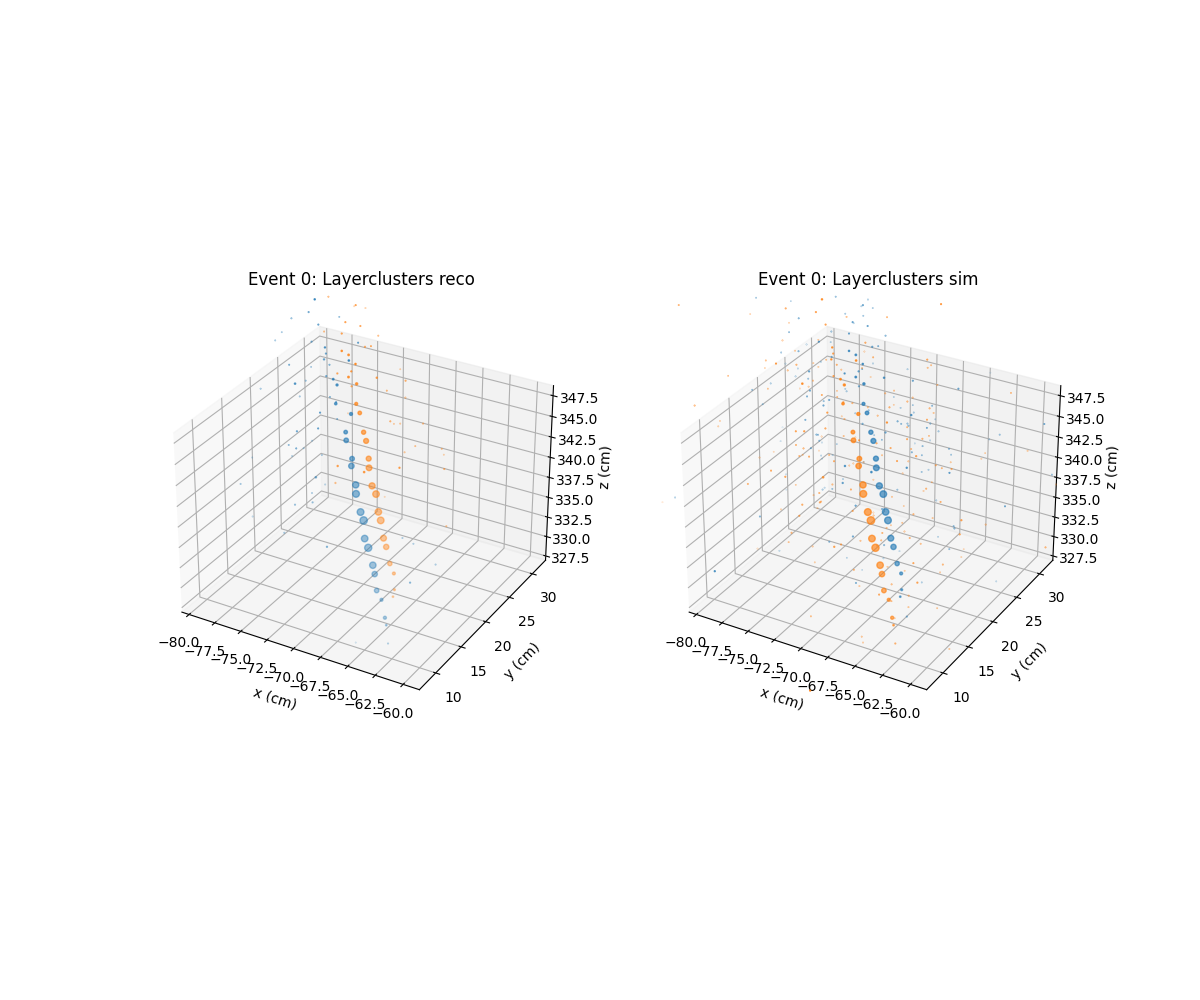

In [239]:
noise = True

reco_total = compute_tree_energy(t_energy, v_multi)
sim_total = compute_tree_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

# compute precision
precision = bcubed(t_vertices, t_indexes, i2rt, i2st)
precision_e = bcubed(t_vertices, t_indexes, i2rt, i2st, e_map=te_map)

# compute recall (with noise or without)
r_vertices = st_vertices if noise else t_vertices
recall = bcubed(r_vertices, st_indexes, i2st, i2rt)
recall_e = bcubed(r_vertices, st_indexes, i2st, i2rt, e_map=ste_map)

print(f"[N] Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {f_score(precision, recall):.2f}")
print(f"[E] Precision: {precision_e:.2f}, Recall: {recall_e:.2f}, F-score: {f_score(precision_e, recall_e):.2f}")
plot_event(tracksters, simtracksters, eid, legend=False)